In [11]:
from ibapi.sync_wrapper import *
import pandas as pd
import numpy as np
from pathlib import Path
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
import akshare as ak
import yfinance as yf

In [3]:
def bars2ohlcv(bars, day_bar=False):
    df = pd.DataFrame.from_dict([{'date': int(bar.date), 'open': bar.open, 'high': bar.high, 'low': bar.low, 'close': bar.close, 'volume': bar.volume} for bar in bars])
    if day_bar:
        df['date'] = pd.to_datetime(df['date'].astype(str), format='%Y%m%d')
    else:
        df['date'] = pd.to_datetime(df['date'], unit='s', utc=True)
    df.set_index('date', inplace=True)
    return df

In [4]:
def choice2ohlcv(dfr):
  dfr['交易时间'] = dfr['交易时间'].dt.tz_localize('Asia/Shanghai')
  dfr['UTC时间'] = dfr['交易时间'].dt.tz_convert('UTC')
  dfr.set_index('UTC时间', inplace=True)
  dfr.index.name = 'date'
  if '成交量' not in dfr.columns:
    dfr['成交量'] = 0
  dfr = dfr.rename(columns={'开盘价': 'open', '最高价': 'high', '最低价': 'low', '收盘价': 'close', '成交量': 'volume'})
  dfr = dfr[['open', 'high', 'low', 'close', 'volume']]
  return dfr.sort_index(ascending=True)

In [52]:
def yf2ohlcv(dfr, day_bar=False):
  label = dfr.columns.get_level_values(1).unique()[0]
  df = dfr.xs(label, axis=1, level=1)
  df.columns = ['close', 'high', 'low', 'open', 'volume']
  if day_bar:
    df.index = pd.to_datetime(df.index)
  else:
    df.index = pd.to_datetime(df.index, utc=True)
  df.index.name = 'date'
  df = df[['open', 'high', 'low', 'close', 'volume']]
  return df.sort_index(ascending=True)

In [6]:
def akshare2ohlcv(dfr):
  dfr['date'] = pd.to_datetime(dfr['datetime'])
  dfr['date'] = dfr['date'].dt.tz_localize('Asia/Shanghai').dt.tz_convert('UTC')
  dfr.set_index('date', inplace=True)
  return dfr[['open', 'high', 'low', 'close', 'volume']]

In [81]:
def merge_df(df1, df2, df3):
    merged_df = pd.merge(df1, df2, left_index=True, right_index=True, how='inner', suffixes=('_1', '_2'))
    merged_df = pd.merge(merged_df, df3, left_index=True, right_index=True, how='inner')
    merged_df.rename(columns={'close_1': 'a0', 'close_2': 'b0', 'close': 'c0'}, inplace=True)
    return merged_df[['a0', 'b0', 'c0']]

def merge_asof(df1, df2, df3):
    df1.dropna(inplace=True)
    df2.dropna(inplace=True)
    df3.dropna(inplace=True)

    merged_df = pd.merge_asof(df1.sort_index(), df2.sort_index(), left_index=True, right_index=True, direction='nearest', tolerance=pd.Timedelta('1 hours'), suffixes=('_1', '_2'))
    merged_df = pd.merge_asof(merged_df.sort_index(), df3.sort_index(), left_index=True, right_index=True, direction='nearest', tolerance=pd.Timedelta('1 hours'))
    merged_df.rename(columns={'close_1': 'a0', 'close_2': 'b0', 'close': 'c0'}, inplace=True)
    return merged_df[['a0', 'b0', 'c0']]

In [99]:
def compare3symbols(symbols, duration, bar_size):
    c1, c2, c3 = symbols
    _, (df1, df2) = compare2symbols((c1, c2), duration, bar_size)
    df3 = get_historical_data(c3, duration, bar_size, "MIDPOINT")
    df = merge_df(df1, df2, df3)
    return df, (df1, df2, df3)

def compare2symbols(symbols, duration, bar_size):
    c1, c2 = symbols

    df1 = get_historical_data(c1, duration, bar_size, "TRADES")
    df2 = get_historical_data(c2, duration, bar_size, "TRADES")

    df = pd.merge(df1, df2, on='date', suffixes=('_1', '_2'), how='inner')
    return df, (df1, df2)

def get_historical_data(contract, duration, bar_size, up_to_date=True):
    use_rth = contract.secType == 'STK'
    what_to_show = 'MIDPOINT' if contract.exchange == 'IDEALPRO' else 'TRADES'

    symbol = contract.symbol if contract.exchange != 'IDEALPRO' else f'{contract.symbol}{contract.currency}'
    filepath = f'data/ibkr/{symbol}-{bar_size.replace(' ', '')}-{what_to_show}.csv'
    path = Path(filepath)
    if path.exists():
        dfe = pd.read_csv(filepath, index_col='date', parse_dates=True)
        now = pd.Timestamp.now(tz=dfe.index.tz)
        _duration = (now - dfe.index[0]).days
        if _duration < duration:
            days = duration
        else:
            days = (now - dfe.index[-1]).days + 1
    else:
        days = duration
        dfe = pd.DataFrame()
    
    # 不需要更新直接返回已有的数据
    if not up_to_date:
        return dfe
    
    day_bar = bar_size.endswith('day')
    dfn = bars2ohlcv(app.get_historical_data(
        contract=contract, 
        end_date_time="", 
        duration_str=days2duration(days),
        bar_size_setting=bar_size,
        what_to_show=what_to_show, 
        use_rth=use_rth,
        format_date=2,
        timeout=24*60*60), day_bar)

    df = pd.concat([dfe, dfn])
    df = df[~df.index.duplicated(keep='first')]
    df = df.sort_index()
    df.to_csv(filepath)
    return df

def days2duration(days):
    if days >= 365:
        years = math.ceil(days / 365)
        return f"{years} Y"
    elif days >= 30:
        months = math.ceil(days / 30)
        return f"{months} M"
    else:
        return f"{days} D"

def get_historical_data_akshare(symbol, bar_size, dfn_fn, up_to_date=True):
    def provider():
        return f'data/akshare/{dfn_fn.__name__}-{symbol}-{bar_size}mins.csv'
    return get_historical_data_from_provider(provider, symbol, bar_size, dfn_fn, up_to_date)

def get_historical_data_yfinance(symbol, bar_size, dfn_fn, up_to_date=True):
    def provider():
        return f'data/yfinance/{dfn_fn.__name__}-{symbol}-{bar_size}.csv'
    return get_historical_data_from_provider(provider, symbol, bar_size, dfn_fn, up_to_date)

def get_historical_data_from_provider(provider_fn, symbol, bar_size, dfn_fn, up_to_date=True):
    filepath = provider_fn()
    path = Path(filepath)
    if path.exists():
        dfe = pd.read_csv(filepath, index_col='date', parse_dates=True)
    else:
        dfe = pd.DataFrame()

    if not up_to_date:
        return dfe
    
    dfn = dfn_fn(symbol, bar_size)

    df = pd.concat([dfe, dfn])
    df = df[~df.index.duplicated(keep='first')]
    df = df.sort_index()
    df.to_csv(filepath)
    return df

def futures_zh_minute_sina(symbol, bar_size):
    return akshare2ohlcv(ak.futures_zh_minute_sina(symbol=symbol, period=bar_size))

def futures_hist_em(symbol, bar_size):
    df = ak.futures_hist_em(symbol=symbol, period=bar_size)
    df['date'] = pd.to_datetime(df['时间'])
    df.set_index('date', inplace=True)
    df = df.rename(columns={'开盘': 'open', '最高': 'high', '最低': 'low', '收盘': 'close', '成交量': 'volume'})
    return df[['open', 'high', 'low', 'close', 'volume']]

def yf_hist(symbol, bar_size):
    yf.config.network.proxy = {
        "http": "http://127.0.0.1:1080",
        "https": "http://127.0.0.1:1080"
    }
    period_map = {
        'm': 'max',
        'h': '730d',
        'd': 'max'
    }
    day_bar = bar_size.endswith('d')
    return yf2ohlcv(yf.download(symbol, period=period_map[bar_size[-1]], interval=bar_size), day_bar)


In [ ]:
app = TWSSyncWrapper(timeout=24 * 60 * 60)
app.connect_and_start(host="127.0.0.1", port=7496, client_id=1)
app.get_current_time()

# app.disconnect_and_stop()

clear_output()

In [9]:
USDJPY = Contract()
USDJPY.symbol = "USD"
USDJPY.secType = "CASH"
USDJPY.exchange = "IDEALPRO"
USDJPY.currency = "JPY"

USDCNH = Contract()
USDCNH.symbol = "USD"
USDCNH.secType = "CASH"
USDCNH.exchange = "IDEALPRO"
USDCNH.currency = "CNH"

GD = Contract()
GD.symbol = "GOLD"
GD.secType = "CONTFUT"
GD.exchange = "OSE.JPN"
GD.currency = "JPY"

M_PT = Contract()
M_PT.symbol = "M-PT"
M_PT.secType = "CONTFUT"
M_PT.exchange = "OSE.JPN"
M_PT.currency = "JPY"

PLAT = Contract()
PLAT.symbol = "PLAT"
PLAT.secType = "CONTFUT"
PLAT.exchange = "OSE.JPN"
PLAT.currency = "JPY"

GC = Contract()
GC.symbol = "GC"
GC.secType = "CONTFUT"
GC.exchange = "COMEX"
GC.currency = "USD"

MGC = Contract()
MGC.symbol = "MGC"
MGC.secType = "CONTFUT"
MGC.exchange = "COMEX"
MGC.currency = "USD"

_1OZ = Contract()
_1OZ.symbol = "1OZ"
_1OZ.secType = "CONTFUT"
_1OZ.exchange = "COMEX"
_1OZ.currency = "USD"

SI = Contract()
SI.symbol = "SI"
SI.secType = "CONTFUT"
SI.exchange = "COMEX"
SI.currency = "USD"

PL = Contract()
PL.symbol = "PL"
PL.secType = "CONTFUT"
PL.exchange = "NYMEX"
PL.currency = "USD"

PPLT = Contract()
PPLT.symbol = "PPLT"
PPLT.secType = "STK"
PPLT.exchange = "SMART"
PPLT.currency = "USD"

In [ ]:
df = get_historical_data(SI, 366, '1 day', up_to_date=False)

In [ ]:
# df, _ = compare2symbols((PPLT, PL), '1 D', '5 mins')
# df['a-b'] = np.log(df['close_2']) - np.log(df['close_1'])

# df1 = choice2ohlcv(pd.read_excel('C:\\Users\\wayne\\Desktop\\kline\\基准\\AG0\\K线导出_AG0_60分钟线数据-251227.xlsx'))
df1 = yf2ohlcv(pd.read_csv('C:\\Users\\wayne\\Desktop\\kline\\基准\\SI-1H.csv', header=[0, 1], index_col=[0]))
df2 = get_historical_data(SI, '1 Y', '1 hour', "TRADES")

df= pd.merge(df1, df2, on='date', how='inner')
df['a'] = df['close_x']
df['b'] = df['close_y']
df['a-b'] = df['a'] - df['b']


In [7]:
# df, (df1, df2, df3) = compare3symbols((M_PT, PL, USDJPY), '1 D', '1 min')

In [116]:
# 分钟级别
# df1 = choice2ohlcv(pd.read_excel('data/choice/K线导出_AG0_5分钟线数据.xlsx'))
df1 = get_historical_data_akshare("AG0", "5", futures_zh_minute_sina, up_to_date=True)
df2 = get_historical_data(SI, 720, '5 mins', up_to_date=False)
df3 = get_historical_data(USDCNH, 720, '5 mins', up_to_date=False)
df = merge_df(df1, df2, df3)

# 120 分钟级别 - ibkr 数据
# df1 = choice2ohlcv(pd.read_excel('C:\\Users\\wayne\\Desktop\\kline\\基准\\AG0\\K线导出_AG0_120分钟线数据.xlsx'))
# df2 = get_historical_data(SI, 720, '2 hours', up_to_date=False)
# df3 = get_historical_data(USDCNH, 720, '2 hours', up_to_date=False)
# df= merge_asof(df1, df2, df3)

# 120 分钟级别 - yf 数据，与 ibkr 相比，向上平移 200 左右
# df1 = choice2ohlcv(pd.read_excel('C:\\Users\\wayne\\Desktop\\kline\\基准\\AG0\\K线导出_AG0_120分钟线数据.xlsx'))
# df2 = get_historical_data_yfinance('SI=F', '1h', yf_hist, up_to_date=True)
# df3 = get_historical_data(USDCNH, 720, '2 hours', up_to_date=False)
# df= merge_asof(df1, df2, df3)

# 日线级别
# df1 = get_historical_data_akshare("沪银主连", "daily", futures_hist_em, up_to_date=False)
# df2 = get_historical_data_yfinance('SI=F', '1d', yf_hist, up_to_date=False)
# df3 = get_historical_data(USDCNH, 7200, '1 day', up_to_date=False)
# df = merge_df(df1, df2, df3)

df['a'] = df['a0'] 
df['b'] = df['b0'] * df['c0'] * 1000 / 31.1034768
df['a-b'] = df['a'] - df['b']

relation: 0.9933589395751162
95%: nan, nan
N (726.7298, 395.2611)


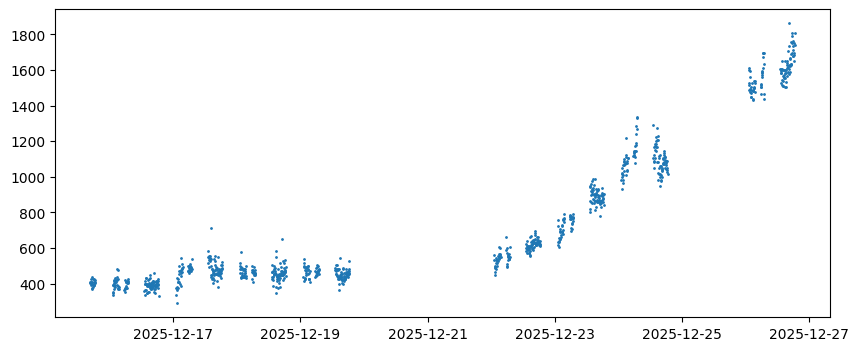

In [117]:
lower, upper = df[df.index < '2025-12-01']['a-b'].quantile([0.025, 0.975])
print(f'relation: {df['a'].corr(df['b'])}')
print(f'95%: {lower:.4f}, {upper:.4f}')
print(f'N ({df['a-b'].mean():.4f}, {df['a-b'].std():.4f})')

plt.figure(figsize=(10, 4))
plt.scatter(df.index, df['a-b'], s=1)
plt.axhline(y=lower, color='r', linestyle='--')
plt.axhline(y=upper, color='r', linestyle='--')
plt.show()

In [118]:
df[df['a-b'] > 1000]

,a0,b0,c0,a,b,a-b
date,,,,,,
2025-12-24 01:10:00+00:00,17248.0,71.915,7.019120,17248.0,16229.054329,1018.945671
2025-12-24 01:15:00+00:00,17250.0,72.035,7.016155,17250.0,16249.267845,1000.732155
2025-12-24 01:25:00+00:00,17364.0,72.320,7.016310,17364.0,16313.917009,1050.082991
2025-12-24 01:30:00+00:00,17335.0,72.330,7.017750,17335.0,16319.521472,1015.478528
2025-12-24 01:45:00+00:00,17407.0,72.665,7.019070,17407.0,16398.189978,1008.810022
...,...,...,...,...,...,...
2025-12-26 18:10:00+00:00,18996.0,76.870,7.004900,18996.0,17312.105218,1683.894782
2025-12-26 18:15:00+00:00,19025.0,76.945,7.004705,19025.0,17328.513776,1696.486224
2025-12-26 18:20:00+00:00,19039.0,77.205,7.004650,19039.0,17386.930944,1652.069056


In [ ]:
yf.config.network.proxy = {
        "http": "http://127.0.0.1:1080",
        "https": "http://127.0.0.1:1080"
    }
# yf.config.network.proxy = None
yf.download('SI=F', period='730d', interval='1h')

$SI=F: possibly delisted; no price data found  (period=731d) (Yahoo error = "1h data not available for startTime=1703750026 and endTime=1766908426. The requested range must be within the last 730 days.")
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SI=F']: possibly delisted; no price data found  (period=731d) (Yahoo error = "1h data not available for startTime=1703750026 and endTime=1766908426. The requested range must be within the last 730 days.")


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,SI=F,SI=F,SI=F,SI=F,SI=F,SI=F
Date,,,,,,
